# Exploring Basics of MNE

MNE is a python library for analysis of electrophysiological time series data: M/EEG.

In [1]:
%matplotlib qt
%matplotlib inline

# Import MNE things
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne import time_frequency as tf
from mne.datasets import eegbci

# Import other
import matplotlib.pyplot as plt
import numpy as np

## Example Data

EEGBCI is a dataset of EEG data, with subjects doing 

Without getting into the details of motor imagery classification, we can start with their rest data, and then treat their data like normal task data. 

In [2]:
# Check out the load data function. Returns file paths to load data
eegbci.load_data?

In [3]:
# Lets get the first subjects data, the eyes closed resting block
ec_f_name = eegbci.load_data(2, [1, 2, 3])  # <- Get a list of paths to requested data

In [4]:
# Load some data from the first subject
ec_dat = read_raw_edf(ec_f_name[0], preload=True)
eo_dat = read_raw_edf(ec_f_name[1], preload=True)
motor_dat = read_raw_edf(ec_f_name[2], preload=True)

Extracting edf Parameters from /Users/thomasdonoghue/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Ready.
Extracting edf Parameters from /Users/thomasdonoghue/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R02.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Ready.
Extracting edf Parameters from /Users/thomasdonoghue/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R03.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.


In [5]:
# Have a quick look at the info - for eyes closed data
ec_dat.info

<Info | 17 non-empty fields
    bads : 'list | 0 items
    buffer_size_sec : 'float | 1.0
    ch_names : 'list | Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., ...
    chs : 'list | 65 items (EEG: 64, MISC: 1)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : 'list | 0 items
    filename : 'str | /Users/tho.../S002R01.edf
    highpass : 'float | 0.0 Hz
    hpi_meas : 'list | 0 items
    hpi_results : 'list | 0 items
    lowpass : 'float | 80.0 Hz
    meas_date : 'int | 1250093700
    nchan : 'int | 65
    projs : 'list | 0 items
    sfreq : 'float | 160.0 Hz
    acq_pars : 'NoneType
    acq_stim : 'NoneType
    ctf_head_t : 'NoneType
    description : 'NoneType
    dev_ctf_t : 'NoneType
    dig : 'NoneType
    experimenter : 'NoneType
    file_id : 'NoneType
    hpi_subsystem : 'NoneType
    kit_system_id : 'NoneType
    line_freq : 'NoneType
    meas_id : 'NoneType
    proj_id : 'NoneType
    pro

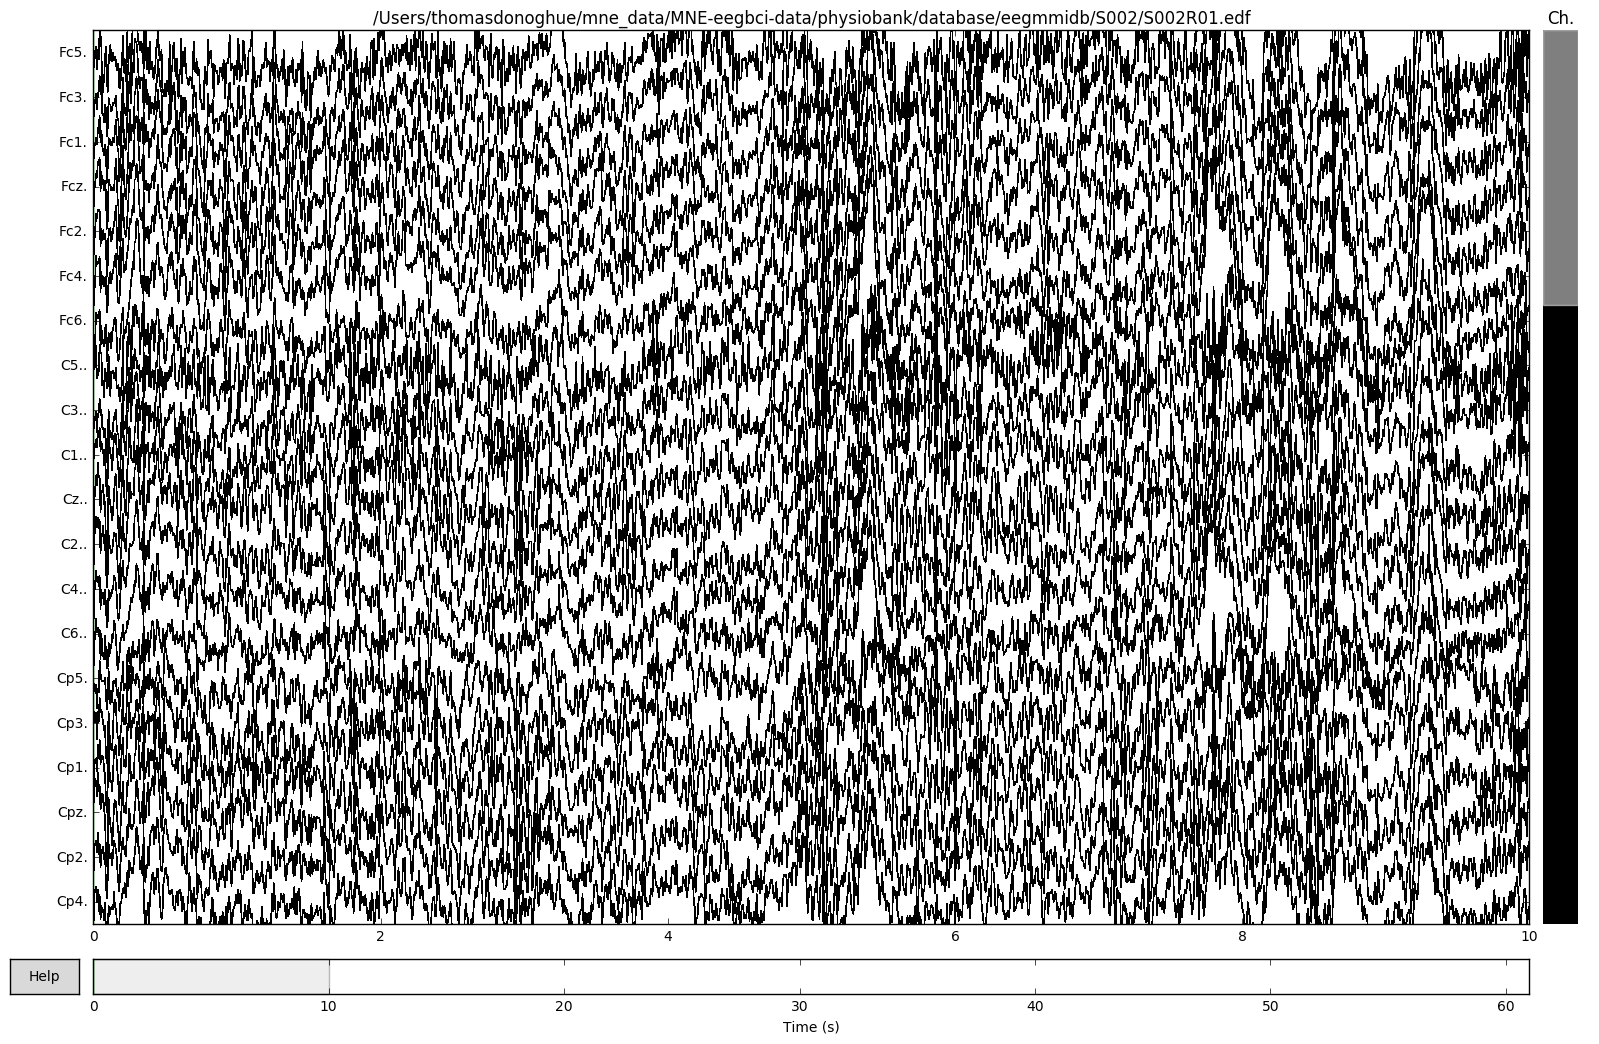

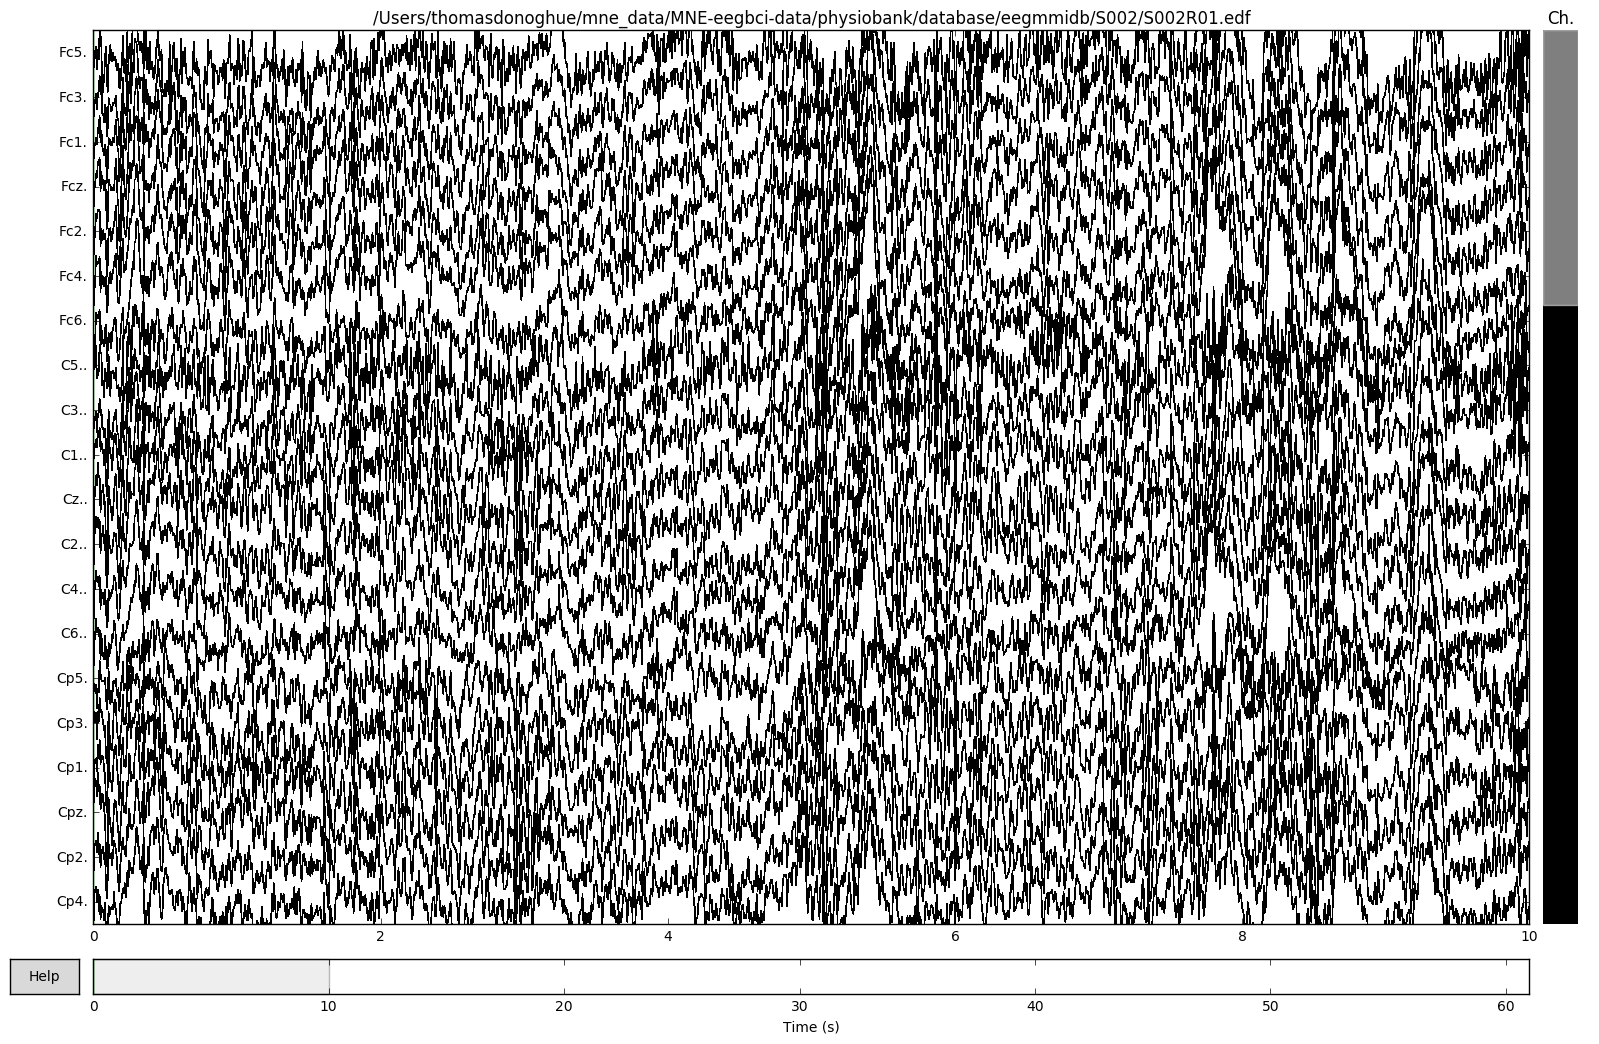

In [6]:
# Plot the eyes-closed (should open interactive viz - can scroll through)
ec_dat.plot()

In [7]:
# Finding the actual data
# 
print(type(ec_dat._data))
print(ec_dat._data.shape)

<class 'numpy.ndarray'>
(65, 9760)


## Epoching

In [8]:
# Check out epoched data object
Epochs?

In [9]:
# Pull out events
events = find_events(motor_dat, stim_channel='STI 014')

Removing orphaned offset at the beginning of the file.
29 events found
Events id: [1 2 3]


In [10]:
# Pick-types extracts the desired channels - here extract eeg chans, ignore stim channel, etc. 
chans = pick_types(motor_dat.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

In [11]:
# Settings for extracting segments of data around the events of interest
t_min, t_max = -0.5, 3
event_id = dict(hands=3, feet=3)

# Extract epochs
epochs = Epochs(motor_dat, events, event_id, t_min, t_max, proj=False,
                picks=chans, baseline=None, preload=True, add_eeg_ref=False)

7 matching events found
No baseline correction applied
Loading data for 7 events and 561 original time points ...
0 bad epochs dropped


In [12]:
# Finding the actual data - epochs
print(type(epochs._data))
print(epochs._data.shape)

<class 'numpy.ndarray'>
(7, 64, 561)


In [14]:
# Average over all epochs
evoked = epochs.average()

# Finding the actual data - evoked
print(type(evoked.data))
print(evoked.data.shape)

<class 'numpy.ndarray'>
(64, 561)


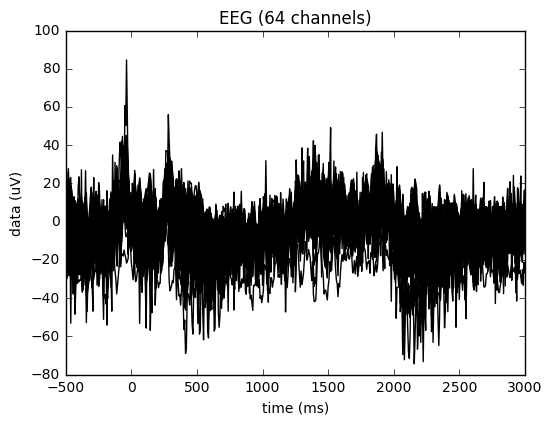

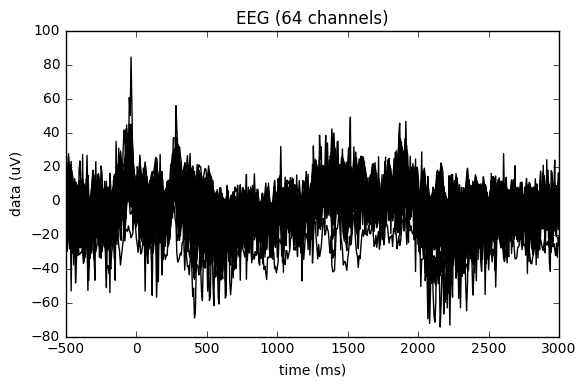

In [15]:
# Look at event-related (averaged) potential - this is typically called an ERP
# In this case, perhaps most noticeable the brain seemd to get more 'positive' about 600 ms after the movement
evoked.plot()

## Power Spectra

In [16]:
# Check out the MNE function that calculates and plots the PSD
ec_dat.plot_psd?

Effective window size : 1.600 (s)


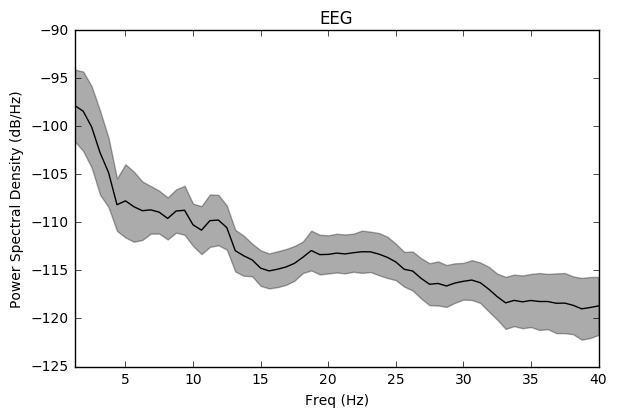

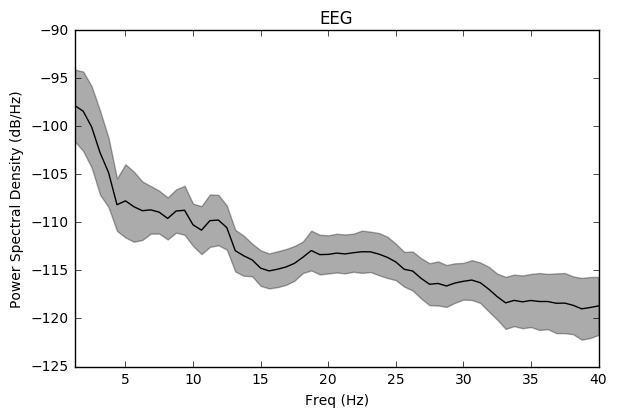

In [17]:
# Check out the PSD
ec_dat.plot_psd(fmin=1, fmax=40, n_fft=256)

In [18]:
# Digging under the hood - timefrequency in MNE

# Check out the MNE Welch's function
tf.psd_welch?

In [19]:
# Calculate PSD with MNE's welch's function
psd, f = tf.psd_welch(ec_dat, fmin=1, fmax=40, n_fft=256)

# Note: MNE also supports PSD calculation by multi-taper
#psd_mt, f_mt = tf.psd_multitaper(ec_dat, fmin=1, fmax=40)

Effective window size : 1.600 (s)


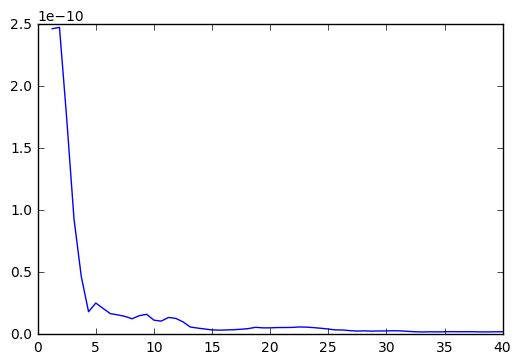

In [20]:
# Average power, all channels
plt.plot(f, np.mean(psd, axis=0))

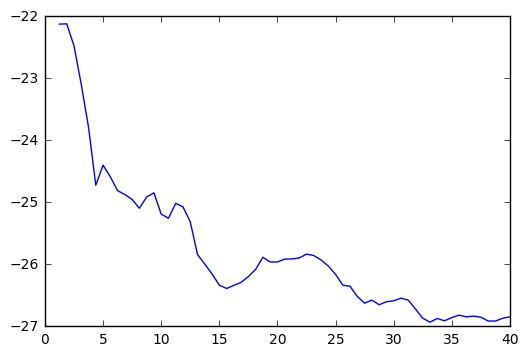

In [21]:
# Log of average power, all channels
plt.plot(f, np.log(np.mean(psd, axis=0)))

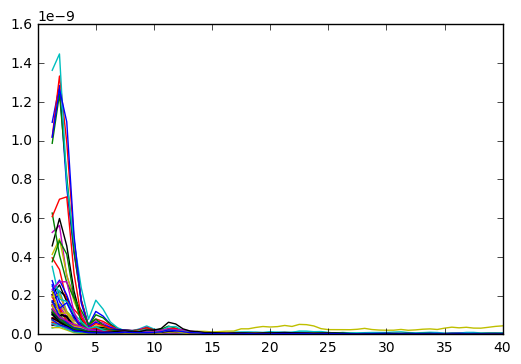

In [22]:
# Power for each channel
n_ch, n_f = psd.shape
for ch in range(n_ch):
    plt.plot(f, psd[ch, :])

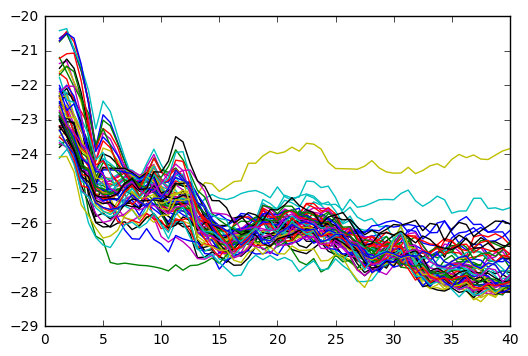

In [23]:
# Log power for each channel
n_ch, n_f = psd.shape
for ch in range(n_ch):
    plt.plot(f, np.log(psd[ch, :]))